## Pretrained CNN models with PennFudanPed dataset

We also can use CNN models for other reasons like object detection.

In [1]:
import os
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
root = os.getcwd()

### Load a Dataset

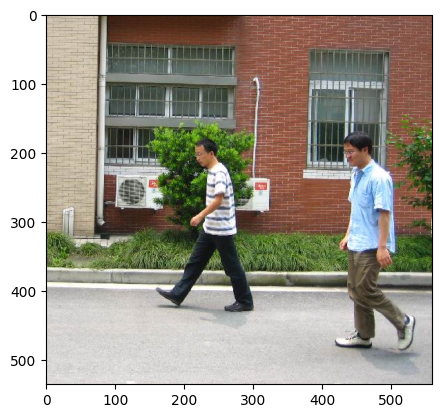

In [4]:
image = Image.open(os.path.join(root,'data/PennFudanPed/PNGImages/FudanPed00001.png'))
plt.imshow(image);

1

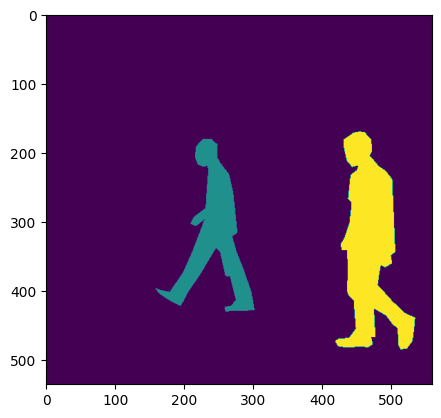

In [5]:
mask = Image.open(os.path.join(root,'data/PennFudanPed/PedMasks/FudanPed00001_mask.png'))
plt.imshow(mask)

np.array(mask)[400,200]

### Dataset preprocessing class

In [6]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, mode='detection'):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
        self.mode = mode
        
        # Change the import mode depending on tasks.
        if not (self.mode == 'detection' or self.mode == 'segmentation'):
            raise ValueError(f"mode {self.mode} is not supproted")
        
    def __getitem__(self, idx):
        # Load images and masks.
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        
        # Object Detection mode
        if self.mode == 'detection':
            obj_ids = np.unique(mask)
            obj_ids = obj_ids[1:] # Remove the  background one.

            masks = mask == obj_ids[:, None, None]

            num_objs = len(obj_ids)

            # Create bounding boxes based on the boundary location of masks of each objects.
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target
        
        # Semantic segmentation mode
        elif self.mode == 'segmentation':
            mask[mask > 0] = 1 # Set 1 if there is an object.

            mask = torch.as_tensor(mask, dtype=torch.uint8)

            target = {}
            target["mask"] = mask

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
# Transformers
class ToTensor(object):
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        return image, target

class Normalize(object):
    def __call__(self, image, target):
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [8]:
infer_transform = Compose([ToTensor(),])

In [9]:
dataset_detection = PennFudanDataset(os.path.join(root,'data/PennFudanPed/'), 
                                     transforms=infer_transform, 
                                     mode='detection')
dataset_detection[0]

(tensor([[[0.8275, 0.8235, 0.8314,  ..., 0.5608, 0.5725, 0.5804],
          [0.7020, 0.6784, 0.6667,  ..., 0.4941, 0.5020, 0.5020],
          [0.8000, 0.7608, 0.7373,  ..., 0.5098, 0.5137, 0.5098],
          ...,
          [0.8863, 0.8510, 0.8275,  ..., 0.7176, 0.7216, 0.7255],
          [0.9059, 0.8588, 0.8235,  ..., 0.7333, 0.7333, 0.7294],
          [0.8824, 0.8902, 0.8431,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7843, 0.7804, 0.7882,  ..., 0.3765, 0.3882, 0.3961],
          [0.6588, 0.6353, 0.6235,  ..., 0.3098, 0.3176, 0.3176],
          [0.7569, 0.7176, 0.6941,  ..., 0.3255, 0.3294, 0.3255],
          ...,
          [0.8627, 0.8275, 0.8039,  ..., 0.7176, 0.7216, 0.7255],
          [0.8824, 0.8353, 0.8000,  ..., 0.7333, 0.7333, 0.7294],
          [0.8588, 0.8667, 0.8196,  ..., 0.7451, 0.7451, 0.7333]],
 
         [[0.7137, 0.7098, 0.7176,  ..., 0.3059, 0.3176, 0.3255],
          [0.5882, 0.5647, 0.5529,  ..., 0.2392, 0.2471, 0.2471],
          [0.6863, 0.6471, 0.6235,  ...,

### Train the Model

In [10]:
# ResNet-50
det_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\yulimy/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [11]:
# Inference the model.
data_loader = DataLoader(dataset_detection, batch_size=1, shuffle=True)


images,targets = next(iter(data_loader))
images = list(image for image in images)

det_model.eval()
predictions = det_model(images)  

In [12]:
targets

{'boxes': tensor([[[ 46.,  70., 176., 365.],
          [198.,  76., 304., 328.],
          [255.,  73., 393., 344.],
          [342.,  52., 420., 277.]]]),
 'labels': tensor([[1, 1, 1, 1]])}

In [13]:
predictions

[{'boxes': tensor([[277.4781, 238.8007, 342.3935, 394.5085],
          [ 45.7248,  65.3120, 175.4086, 364.1098],
          [206.7586,  71.8793, 306.3287, 339.6882],
          [333.5504,  50.6128, 422.5210, 269.3953],
          [287.6517,  68.3542, 391.2167, 355.1465],
          [380.2122,  59.8789, 425.0144, 221.7817],
          [380.3237,  58.1530, 421.4868, 137.4016],
          [385.3527, 298.7209, 452.0000, 393.8282],
          [380.9319,  57.4120, 411.1673, 107.6947],
          [217.6268,  61.7440, 425.7567, 318.0646],
          [343.9921, 137.3165, 417.7718, 267.1841],
          [319.3315,   3.5352, 396.8414,  71.3685],
          [392.6625,  59.8043, 438.0404, 122.2556],
          [229.5518, 142.4512, 254.7507, 160.2952],
          [276.0234,  49.1076, 291.8681,  71.7355],
          [440.2868,  88.5836, 451.9706, 142.8919],
          [305.4323,  80.5334, 330.9833, 130.4748],
          [137.9709, 116.4995, 168.8600, 195.3529],
          [154.2723, 128.0010, 169.5916, 180.8501],
   

### Predictions

In [14]:
# Object classes
COCO_labels = np.array(open(os.path.join(root,"data/COCO_labels.txt")).read().splitlines())
COCO_labels

array(['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
       'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
       'street sign', 'stop sign', 'parking meter', 'bench', 'bird',
       'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
       'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses',
       'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
       'sports ball', 'kite', 'baseball bat', 'baseball glove',
       'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate',
       'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
       'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
       'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
       'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv',
       'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
       'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book

In [15]:
COCO_labels[predictions[0]['labels']]

array(['fire hydrant', 'person', 'person', 'person', 'person', 'person',
       'person', 'backpack', 'person', 'person', 'person', 'potted plant',
       'person', 'handbag', 'person', 'person', 'person', 'backpack',
       'backpack', 'handbag', 'backpack', 'person', 'person',
       'fire hydrant', 'potted plant', 'person', 'handbag',
       'fire hydrant', 'tie', 'person', 'person', 'person', 'handbag',
       'handbag', 'chair', 'handbag', 'handbag', 'handbag', 'bowl',
       'person', 'person', 'handbag', 'handbag', 'car', 'handbag',
       'handbag', 'person'], dtype='<U14')

In [16]:
# Visualize the result.
from PIL import ImageDraw

In [17]:
def draw_bounding_boxes(image, boxes, labels, pred=False, confs=None, confidence_th=None):

    if pred:
        valid = np.where(confs>confidence_th)
        boxes = boxes[valid]
        labels = labels[valid]

    img_to_draw = Image.fromarray(image)
    draw = ImageDraw.Draw(img_to_draw)

    for i, bbox in enumerate(boxes):
        draw.rectangle(bbox)
        draw.text((bbox[0]+2,bbox[1]+2), str(labels[i]))

    return img_to_draw

In [18]:
image = (images[0].permute(1,2,0).numpy()*255).astype(np.uint8)

gt_boxes = targets['boxes'].detach().numpy()[0]
gt_labels = COCO_labels[targets['labels']][0]
gt_bbox_img = draw_bounding_boxes(image, gt_boxes, gt_labels)

prediction = predictions[0]

boxes = prediction['boxes'].detach().numpy()
labels = COCO_labels[predictions[0]['labels']]
conf = prediction['scores'].detach().numpy()

In [19]:
conf_th = 0.7
bbox_img = draw_bounding_boxes(image, boxes, labels, pred=True, confs=conf, confidence_th=conf_th)

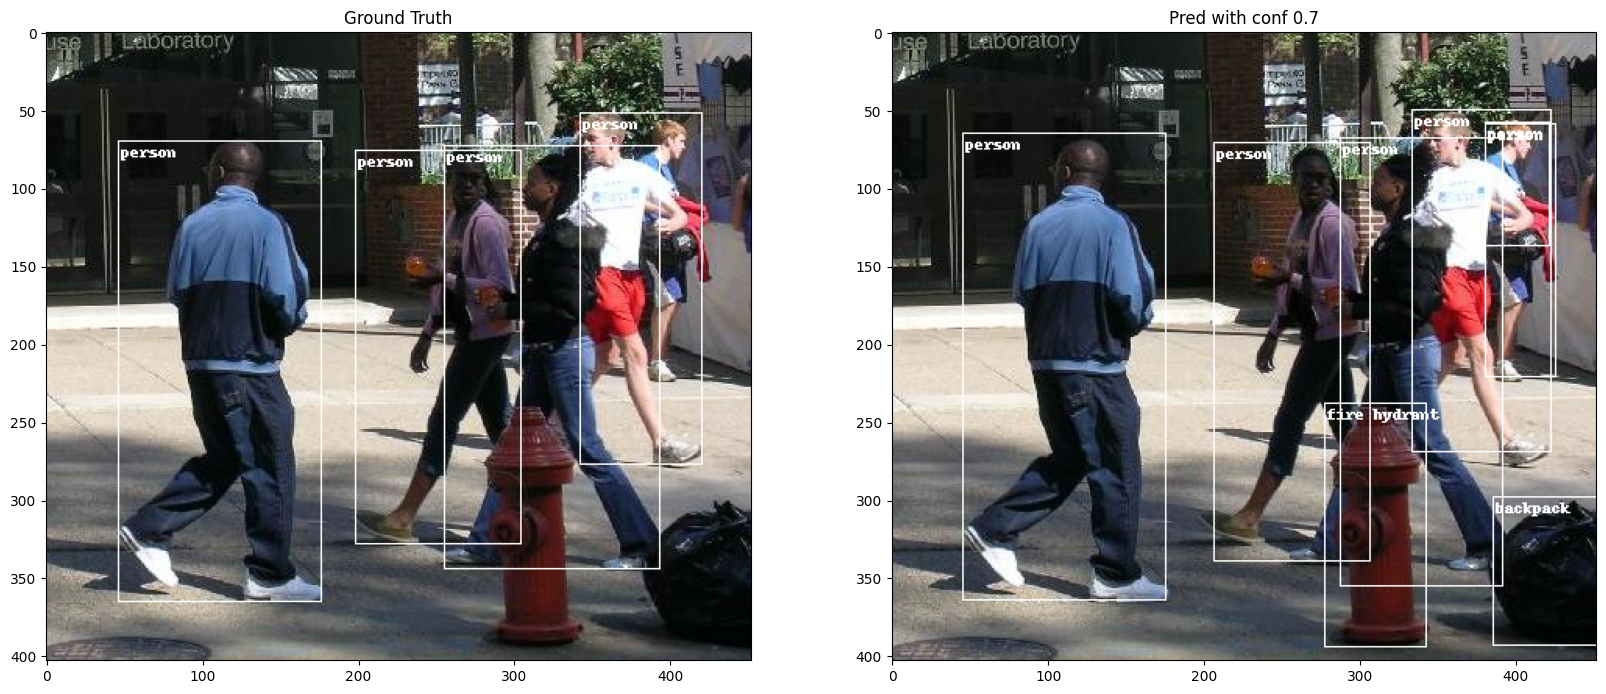

In [20]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(gt_bbox_img)
ax.title.set_text("Ground Truth")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(bbox_img)
ax.title.set_text(f"Pred with conf {conf_th}");